In [644]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from sklearn.linear_model import LinearRegression
from pprint import pprint

In [645]:
# Read the CSV file and clean up junk rows created by log dump
df = pd.read_csv('data/dhs_building_ups_battery_1.csv', header=2)

# Drop row defining unit of data
df = df.drop(index=0)

# Drop the 8 empty columns, need to figure out in what cases they are present
df = df.drop(df.iloc[:, 1:9], axis = 1)
df.head(5)

# Changes Battery Capacity and Runtime Remaining to a float, sometimes it gets imported as a string.
df['Battery Capacity.1'] = df['Battery Capacity.1'].astype(float)
df['Runtime Remaining (Min)'] = df['Runtime Remaining (Min)'].astype(float)

In [646]:
# Create a DataFrame for plotting observed data 

# Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Filter rows based on timestamp
cutoff_time = pd.to_datetime('2023-05-23 12:14')
filtered_df = df[df['timestamp'] >= cutoff_time]

# Set the desired start and end time for plotting
start_time = pd.to_datetime('2023-05-23 12:14')
end_time = pd.to_datetime('2023-05-23 14:01')

# Filter rows after start time and before end time
filtered_df = filtered_df[(filtered_df['timestamp'] >= start_time) & (filtered_df['timestamp'] <= end_time)]

# Transform timestamp column to minutes elapsed betweeen start_time and end_time
filtered_df['Minutes Elapsed'] = (filtered_df['timestamp'] - start_time).dt.total_seconds() / 60
filtered_df = filtered_df.reset_index(drop=True)

In [647]:
# Create a new DataFrame for prediction
prediction_df = pd.DataFrame()
prediction_df['timestamp'] = filtered_df['timestamp']
prediction_df['Runtime Remaining (Min)'] = filtered_df['Runtime Remaining (Min)']

# Remove rows with missing values
prediction_df = prediction_df.dropna()

# Convert timestamp to minutes elapsed from the start time
prediction_df['Minutes Elapsed'] = (prediction_df['timestamp'] - start_time).dt.total_seconds() / 60

# Train a linear regression model
model = LinearRegression()
model.fit(prediction_df[['Minutes Elapsed']], prediction_df['Runtime Remaining (Min)'])

# Create a range of minutes for prediction
minutes_range = pd.DataFrame({'Minutes Elapsed': range(0, int((end_time - start_time).total_seconds() / 60) + 1)})

# Predict battery drain using the linear regression model
predicted_drain = model.predict(minutes_range[['Minutes Elapsed']])

In [648]:
# Calculate the average battery capacity lost every minute
total_capacity_lost = filtered_df['Battery Capacity.1'].iloc[-1] - filtered_df['Battery Capacity.1'].iloc[0]
total_minutes = (end_time - start_time).total_seconds() / 60
average_capacity_lost_per_minute = total_capacity_lost / total_minutes

# Display the average battery capacity lost per minute
print(f"Average battery capacity lost per minute: {average_capacity_lost_per_minute:.2f}%")

Average battery capacity lost per minute: -0.33%


Starting Point:
Timestamp: 12:14
Runtime Remaining (Min): 299.0

Ending Point:
Timestamp: 14:01
Runtime Remaining (Min): 194.0

Total Change in Runtime:  105.0 min


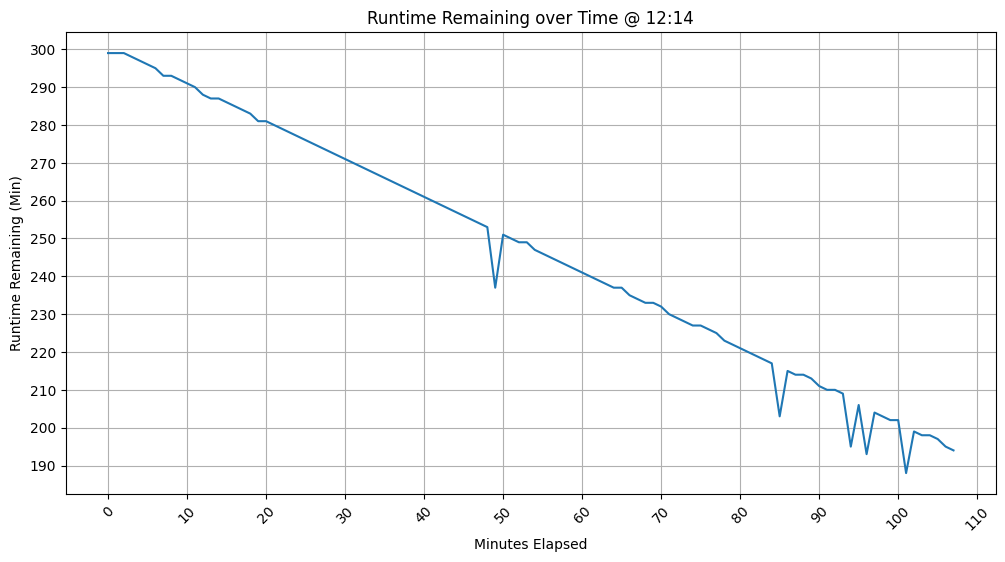

In [649]:
# Plot the data for Runtime Remaining over Time
fig, ax = plt.subplots(figsize=(12, 6)) 
ax.plot(filtered_df['Minutes Elapsed'], filtered_df['Runtime Remaining (Min)'])
ax.set_xlabel('Minutes Elapsed')
ax.set_ylabel('Runtime Remaining (Min)')
ax.set_title('Runtime Remaining over Time @ ' + start_time.strftime("%H:%M"))

loc_x = plticker.MultipleLocator(base=10.0)
loc_y = plticker.MultipleLocator(base=10.0)
ax.xaxis.set_major_locator(loc_x)
ax.yaxis.set_major_locator(loc_y)

plt.xticks(rotation=45)
plt.grid(True)

# Print data at starting and ending points
start_data = filtered_df.iloc[0]
end_data = filtered_df.iloc[-1]

# Calculate total change in runtime
total_change = filtered_df['Runtime Remaining (Min)'].iloc[-1] - filtered_df['Runtime Remaining (Min)'].iloc[0]

print("Starting Point:")
print("Timestamp:", start_time.strftime("%H:%M"))
print("Runtime Remaining (Min):", start_data['Runtime Remaining (Min)'])

print("\nEnding Point:")
print("Timestamp:", end_time.strftime("%H:%M"))
print("Runtime Remaining (Min):", end_data['Runtime Remaining (Min)'])

print("\nTotal Change in Runtime: ", -(total_change), "min")

Starting Point:
Timestamp: 12:14
Battery Capacity: 100.0

Ending Point:
Timestamp: 14:01
Battery Capacity: 65.0

Total Battery Capacity drain:  35.0 min


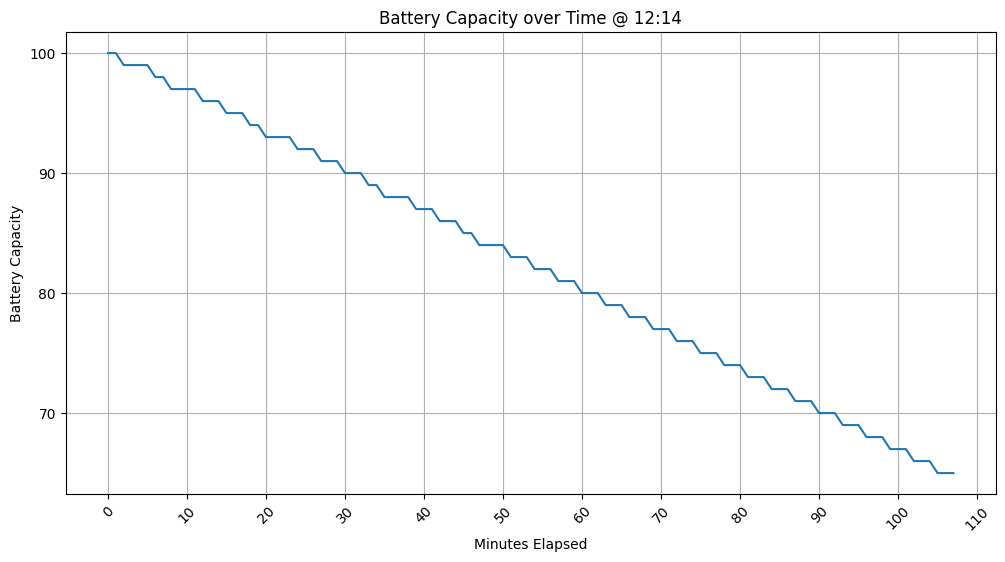

In [ ]:
# Plot the data for Battery Capacity over Time
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(filtered_df['Minutes Elapsed'], filtered_df['Battery Capacity.1'])
ax.set_xlabel('Minutes Elapsed')
ax.set_ylabel('Battery Capacity')
ax.set_title('Battery Capacity over Time @ ' + start_time.strftime("%H:%M"))

loc_x = plticker.MultipleLocator(base=10.0)
loc_y = plticker.MultipleLocator(base=10.0)
ax.xaxis.set_major_locator(loc_x)
ax.yaxis.set_major_locator(loc_y)

plt.xticks(rotation=45)
plt.grid(True)

# Print data at starting and ending points
start_data = filtered_df.iloc[0]
end_data = filtered_df.iloc[-1]

# Calculate total change in runtime
total_change = filtered_df['Battery Capacity.1'].iloc[-1] - filtered_df['Battery Capacity.1'].iloc[0]

print("Starting Point:")
print("Timestamp:", start_time.strftime("%H:%M"))
print("Battery Capacity:", start_data['Battery Capacity.1'])

print("\nEnding Point:")
print("Timestamp:", end_time.strftime("%H:%M"))
print("Battery Capacity:", end_data['Battery Capacity.1'])

print("\nTotal Battery Capacity drain: ", -(total_change), "min")

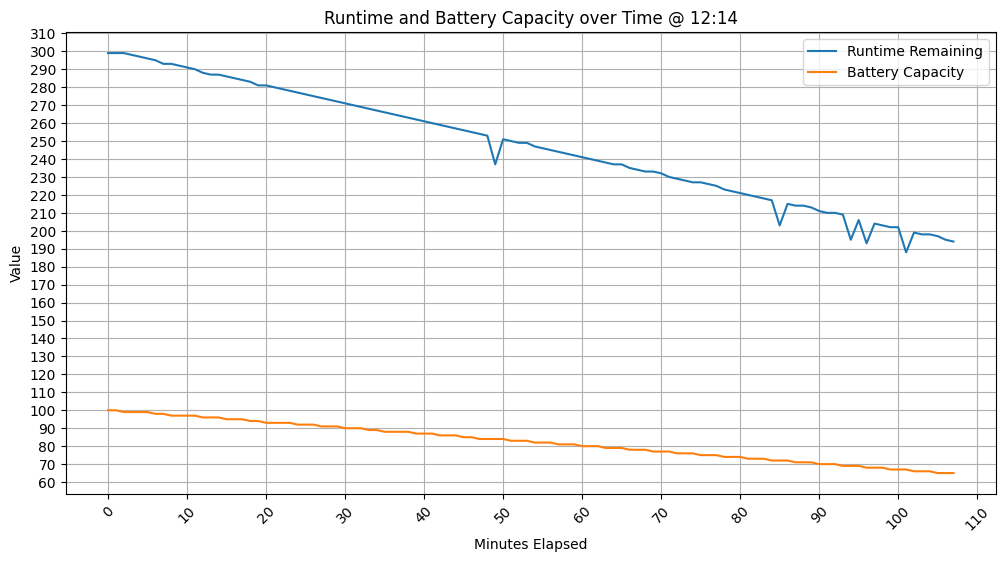

In [ ]:
# Plot the data for both overlayed
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(filtered_df['Minutes Elapsed'], filtered_df['Runtime Remaining (Min)'], label='Runtime Remaining')
ax.plot(filtered_df['Minutes Elapsed'], filtered_df['Battery Capacity.1'], label='Battery Capacity')
ax.set_xlabel('Minutes Elapsed')
ax.set_ylabel('Value')
ax.set_title('Runtime and Battery Capacity over Time @ ' + start_time.strftime("%I:%M"))

loc_x = plticker.MultipleLocator(base=10.0)
loc_y = plticker.MultipleLocator(base=10.0)
ax.xaxis.set_major_locator(loc_x)
ax.yaxis.set_major_locator(loc_y)

plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

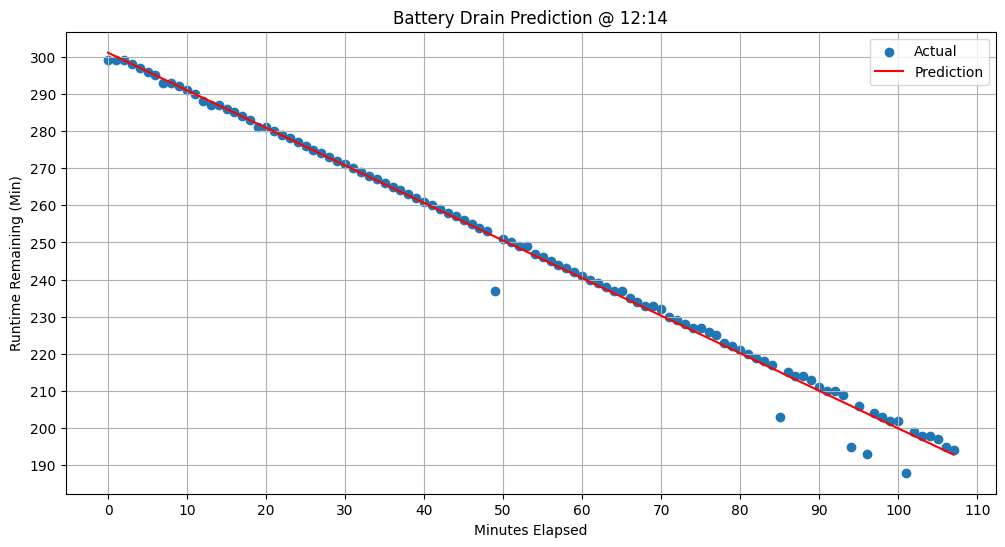

In [ ]:
# Plot the data and prediction
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(prediction_df['Minutes Elapsed'], prediction_df['Runtime Remaining (Min)'], label='Actual')
ax.plot(minutes_range['Minutes Elapsed'], predicted_drain, color='red', label='Prediction')
ax.set_xlabel('Minutes Elapsed')
ax.set_ylabel('Runtime Remaining (Min)')
ax.set_title('Battery Drain Prediction @ ' + start_time.strftime("%I:%M"))

loc_x = plticker.MultipleLocator(base=10.0)
loc_y = plticker.MultipleLocator(base=10.0)
ax.xaxis.set_major_locator(loc_x)
ax.yaxis.set_major_locator(loc_y)

plt.grid(True)
plt.legend()